# COMP 534 - Applied Artificial Intelligence
## CA2 - Neural network regression
This notebook was produced as a deliverable for a group project for the above module, as part of the 2021-2022 Data Science and Artificial Intelligence MSc course at the University of Liverpool.
### Preparation
#### Setup
Import required libraries, tools and classifiers.

In [272]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Hyperparameter optimisation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error

from tensorflow import keras

from keras.callbacks import EarlyStopping

from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

from tensorflow import get_logger

In [273]:
get_logger().setLevel('ERROR')

#### Data
https://www.kaggle.com/datasets/harlfoxem/housesalesprediction

In [2]:
df = pd.read_csv('kc_house_data.csv')

In [3]:
# print(df.shape)
# df.head()

In [4]:
# df.hist(figsize=(20,20), bins='auto')
# plt.tight_layout()

#### Cleaning


##### Remove outliers

In [5]:
originalRowCount = df.shape[0]

df = df[(df['bedrooms'] > 0) & (df['bedrooms'] < 12)]
df = df[(df['bathrooms'] > 0) & (df['bathrooms'] < 12)]
df = df[df['sqft_lot'] < 5e5]
df = df[df['sqft_lot15'] < 3.5e5]

print(f'{((originalRowCount - df.shape[0])*100 / originalRowCount):.2f}% of rows removed')

0.22% of rows removed


##### Date

In [6]:
df['date'] = pd.to_datetime(df['date'])
df['daysSinceSale'] = (df['date'].max() - df['date']).dt.days

##### Binning

In [7]:
bins = 9
df['basementOrdinal'] = pd.cut(df[df['sqft_basement']>0]['sqft_basement'], bins, labels=range(1, bins+1)).astype(int)
df['basementOrdinal'] = df['basementOrdinal'].fillna(0)

In [8]:
bins = 9
df['renovatedOrdinal'] = pd.cut(df[df['yr_renovated']>0]['yr_renovated'], bins, labels=range(1, bins+1)).astype(int)
df['renovatedOrdinal'] = df['renovatedOrdinal'].fillna(0)

##### Transforms

In [9]:
skewedVariables = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15'] #'price', 
logVariables = ['priceLog', 'sqft_livingLog', 'sqft_lotLog', 'sqft_aboveLog', 'sqft_living15Log', 'sqft_lot15Log'] #'priceLog', 
df[logVariables] = np.log(df[skewedVariables])

##### Drop unused columns

In [10]:
df = df.drop(columns=skewedVariables)
df = df.drop(columns=['date', 'id', 'sqft_basement', 'yr_renovated', 'zipcode',])

##### Move price col

In [11]:
column_to_move = df.pop("priceLog")
df.insert(0, "priceLog", column_to_move)

In [12]:
# df.hist(bins = "auto", figsize = (20,20))
# plt.show()

#### Splitting

In [14]:
data = df.values
X = data[:, 1:]
y = data[:, 0].reshape(-1, 1)

In [15]:
# Split data into 80% train and 20% test sets
# Data stratified by class due to imbalance in classes (65% negative - 35% positive)
# Data shuffled to reduce any bias in the order of the dataset
# Define random state to ensure the same train test split can be used for each method
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    #stratify=y,
                                                    shuffle=True,
                                                    random_state=123,
                                                    )

In [16]:
# Standardise features to negate the impact of different feature units
# Updated features have mean 0 and standard deviation 1
featureScaler = MinMaxScaler() #StandardScaler()
# featureScaler.fit(X_train[:, -5:])
# X_train[:, -5:] = featureScaler.transform(X_train[:, -5:])
# X_test[:, -5:] = featureScaler.transform(X_test[:, -5:])

featureScaler.fit(X_train)
X_train = featureScaler.transform(X_train)
X_test = featureScaler.transform(X_test)

In [17]:
targetScaler = StandardScaler()
targetScaler.fit(y_train)
y_train = targetScaler.transform(y_train)
y_test = targetScaler.transform(y_test)

### Models and Analysis

#### Choice of loss function

In [174]:
# define base model
def lossModel(loss):
    # create model
    model = Sequential()
    model.add(Dense(units=24, input_shape=(18,),  activation='relu'))
    model.add(Dense(units=24, activation='relu'))
#     model.add(Dense(16, input_dim=8, activation='relu'))
#     model.add(Dense(16, input_dim=8, activation='relu'))
    model.add(Dense(units=1, activation='linear'))
    # Compile model
    model.compile(loss=loss, optimizer='SGD')
    return model

In [175]:
X_trainLoss, X_validateLoss, y_trainLoss, y_validateLoss = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.20,
                                                    #stratify=y,
                                                    shuffle=False,
                                                    #random_state=123,
                                                    )

In [184]:
modelMSE = lossModel('mean_squared_error')
modelMAE = lossModel('mean_absolute_error')

names = ['MSE', 'MAE']
epochs = 100

histDict = {}
predDict = {}

for i, model in enumerate([modelMSE, modelMAE]):
    
    historyModel = model.fit(X_trainLoss,
                    y_trainLoss,
                    validation_data=(X_validateLoss,
                                     y_validateLoss),
                    epochs=epochs,
                    batch_size=32,
                    verbose=0,
                   )
    
    histDict[names[i]] = historyModel.history
    
    y_validateLossPred = model.predict(X_validateLoss)
    
    predDict[names[i]] = y_validateLossPred
    

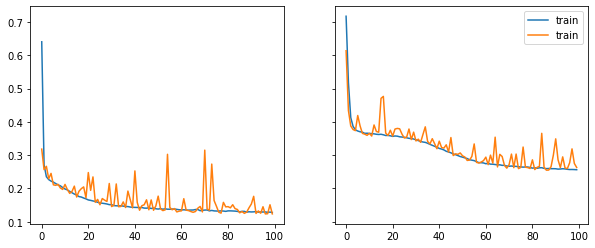

In [191]:
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)

#axs[0] = sns.lineplot(y=histDict['MSE']['loss'])

axs[0].plot(histDict['MSE']['loss'], label='train')
axs[0].plot(histDict['MSE']['val_loss'], label='train')

axs[1].plot(histDict['MAE']['loss'], label='train')
axs[1].plot(histDict['MAE']['val_loss'], label='train')
# ax.plot(historyMSE.history['val_loss'], label='valid', alpha=0.8)

# #ax.set(yscale="log") #xscale="log", 

# ax.set_ylim([0, 0.5])

plt.legend()

In [215]:
def invert(data):
    return np.exp(targetScaler.inverse_transform(data).reshape(data.shape[0]))

In [216]:
MSEpredictionsPlot = invert(predDict['MSE'])
MAEpredictionsPlot = invert(predDict['MAE'])
trueValuesPlot = invert(y_validateLoss)

Text(3.200000000000003, 0.5, 'Prediction')

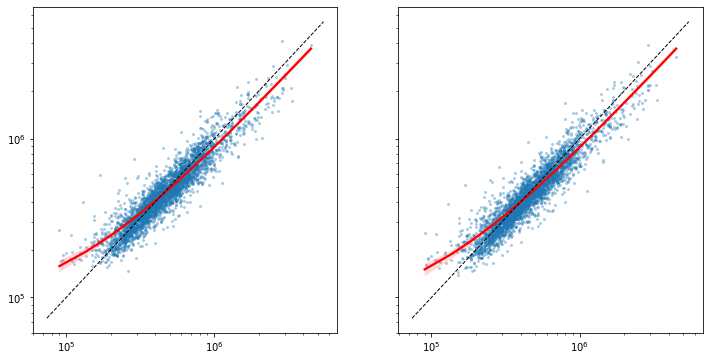

In [217]:
fig, axs = plt.subplots(1, 2, figsize=(12,6), sharey=True)

sns.regplot(ax=axs[0],
                   x=trueValuesPlot,
                 y=MSEpredictionsPlot,
                 scatter_kws={'s':4,
                              'alpha':0.3},   
            line_kws={"color": "red"},   
               )

sns.regplot(ax=axs[1],
                   x=trueValuesPlot,
                 y=MAEpredictionsPlot,
                 scatter_kws={'s':4,
                              'alpha':0.3,
                              #"color": "black"
                             },
            line_kws={"color": "red"},                
               )

axs[0].set(xscale="log", yscale="log")
axs[1].set(xscale="log", yscale="log")

xpoints0 = ypoints0 = axs[0].get_xlim()
axs[0].plot(xpoints0, ypoints0, linestyle='--', color='k', lw=1)#, scalex=False, scaley=False)

xpoints1 = ypoints1 = axs[1].get_xlim()
axs[1].plot(xpoints1, ypoints1, linestyle='--', color='k', lw=1)#, scalex=False, scaley=False)

#ax = sns.lineplot(x=[0,1], y=[0,1])#, transform=ax.transAxes)

#ax.axis('equal')

ax.set_xlabel('Target')
ax.set_ylabel('Prediction')

https://coderzcolumn.com/tutorials/artifical-intelligence/scikeras-give-scikit-learn-like-api-to-your-keras-networks

#### Grid search: learning rate, batch size and optimiser

In [44]:
searchSpace = {
    'optimizer':[SGD, RMSprop, Adam],
    'optimizer__learning_rate': [0.001, 0.01, 0.1],
    'batch_size':[16, 32, 64, 128],
}

In [45]:
#aModel = model()
es = EarlyStopping(monitor='loss', mode='min', verbose=0, patience=5)

estimator = KerasRegressor(model=model,
                           #model=aModel,
                           #optimizer='adam',
                           loss=keras.losses.mean_squared_error,
                           epochs=100,
                           #batch_size=128,
                           verbose=0,
                           callbacks=[es],
                          )

kfold = KFold(n_splits=3)

hyperparameterSearch = GridSearchCV(estimator, searchSpace, scoring='neg_mean_squared_error', n_jobs=-1, cv=kfold)
# Fit search with training data
# Performs search over searchSpace
search = hyperparameterSearch.fit(X_train, y_train)

# results = cross_val_score(estimator, X_train, y_train, cv=kfold)



# results.mean()

In [46]:
# Store best parameters found
optimumParameters = search.best_params_
print(optimumParameters)
# Store all results in new dataframe
results = pd.DataFrame(search.cv_results_)
#results

{'batch_size': 32, 'optimizer': <class 'keras.optimizer_v2.adam.Adam'>}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,80.440343,2.433637,1.068488,0.636476,32,<class 'keras.optimizer_v2.gradient_descent.SGD'>,"{'batch_size': 32, 'optimizer': <class 'keras....",-0.128661,-0.124419,-0.146395,-0.133158,0.009519,7
1,81.961909,4.341576,4.065589,3.957781,32,<class 'keras.optimizer_v2.rmsprop.RMSprop'>,"{'batch_size': 32, 'optimizer': <class 'keras....",-0.108810,-0.112521,-0.150403,-0.123911,0.018794,6
2,74.713246,6.046880,3.481509,3.379967,32,<class 'keras.optimizer_v2.adam.Adam'>,"{'batch_size': 32, 'optimizer': <class 'keras....",-0.110851,-0.111943,-0.110561,-0.111119,0.000595,1
3,54.823495,0.227779,0.641946,0.296512,64,<class 'keras.optimizer_v2.gradient_descent.SGD'>,"{'batch_size': 64, 'optimizer': <class 'keras....",-0.141127,-0.139151,-0.132729,-0.137669,0.003585,8
4,45.202049,4.282840,0.889321,0.152454,64,<class 'keras.optimizer_v2.rmsprop.RMSprop'>,"{'batch_size': 64, 'optimizer': <class 'keras....",-0.110979,-0.116794,-0.124175,-0.117316,0.005400,3
5,47.188475,7.857855,0.921673,0.537704,64,<class 'keras.optimizer_v2.adam.Adam'>,"{'batch_size': 64, 'optimizer': <class 'keras....",-0.113811,-0.115654,-0.111679,-0.113715,0.001624,2
6,28.358028,12.931547,4.079408,4.320378,128,<class 'keras.optimizer_v2.gradient_descent.SGD'>,"{'batch_size': 128, 'optimizer': <class 'keras...",-0.220469,-0.202858,-0.188548,-0.203958,0.013055,9
7,28.879340,0.337140,0.923900,0.270856,128,<class 'keras.optimizer_v2.rmsprop.RMSprop'>,"{'batch_size': 128, 'optimizer': <class 'keras...",-0.117214,-0.116804,-0.124037,-0.119352,0.003317,4
8,24.576255,3.128622,0.283877,0.134047,128,<class 'keras.optimizer_v2.adam.Adam'>,"{'batch_size': 128, 'optimizer': <class 'keras...",-0.121113,-0.125713,-0.115146,-0.120657,0.004326,5


In [73]:
resultsLong = pd.melt(results,
                        id_vars=['param_batch_size', 'param_optimizer'],
                        var_name='splitNumber',
                        value_name='MSE',
                        value_vars=['split0_test_score', 'split1_test_score', 'split2_test_score'])

resultsLong['Optimiser'] = resultsLong['param_optimizer'].apply(lambda x: x.__name__)

[None]

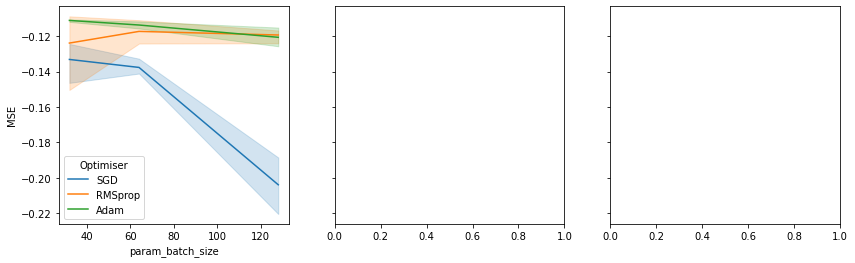

In [81]:
fig, axs = plt.subplots(1, 3, figsize=(14,4), sharey=True)

sns.lineplot(ax=axs[0],
             data=resultsLong,
             x='param_batch_size',
             y='MSE',
             hue='Optimiser',
             #y
            )

ax.set(xscale="log")#, yscale="log")

#### Neural network structure (layers, nodes and activ func)

In [312]:
def newModel(layers, nodes, actFunc):
    model = Sequential()
    model.add(Dense(units=nodes, input_shape=(18,),  activation=actFunc))
    
    for layer in range(layers-1):
        model.add(Dense(units=nodes, activation=actFunc))
        
    model.add(Dense(units=1, activation='linear'))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [313]:
def NNTester(aModel):#layers, nodes, actFunc):

    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)

    estimator = KerasRegressor(model=aModel,#newModel(layers, nodes, actFunc),

#                                optimizer='adam',
#                                loss=keras.losses.mean_squared_error,
                               epochs=1000,
                               batch_size=128,
                               verbose=0,
                               callbacks=[es],
                              )

    kfold = KFold(n_splits=2)

    return cross_val_score(estimator, X_train, y_train, cv=kfold)

    # results.mean()

In [314]:
layers = [2, 3, 4]
nodes = [8, 16, 32]
actFuncs = ['relu', 'sigmoid']

In [316]:
df2 = pd.DataFrame(columns=['layers','nodes','activationFunction','trial1','trial2'])#,'3'])

for layer in layers:
    
    for node in nodes:
        
        for func in actFuncs:
            
            myModel = newModel(layer, node, func)
            results = NNTester(myModel)
            
            #nums = np.array([1,2,3])
            
            myList = [layer, node, func]
            myList.extend(results)
            
            df2.loc[len(df2)]=myList
            
            
df2

Epoch 00154: early stopping
Epoch 00133: early stopping
Epoch 00247: early stopping
Epoch 00315: early stopping
Epoch 00153: early stopping
Epoch 00106: early stopping
Epoch 00341: early stopping
Epoch 00387: early stopping
Epoch 00099: early stopping
Epoch 00102: early stopping
Epoch 00069: early stopping
Epoch 00052: early stopping
Epoch 00144: early stopping
Epoch 00189: early stopping
Epoch 00329: early stopping
Epoch 00271: early stopping
Epoch 00094: early stopping
Epoch 00087: early stopping
Epoch 00051: early stopping
Epoch 00224: early stopping
Epoch 00080: early stopping
Epoch 00088: early stopping
Epoch 00076: early stopping
Epoch 00041: early stopping
Epoch 00149: early stopping
Epoch 00097: early stopping
Epoch 00148: early stopping
Epoch 00307: early stopping
Epoch 00091: early stopping
Epoch 00072: early stopping
Epoch 00172: early stopping
Epoch 00049: early stopping
Epoch 00048: early stopping
Epoch 00098: early stopping
Epoch 00047: early stopping
Epoch 00046: early s

,layers,nodes,activationFunction,trial1,trial2
0,2,8,relu,0.866505,0.865235
1,2,8,sigmoid,0.796594,0.808008
2,2,16,relu,0.863936,0.865586
3,2,16,sigmoid,0.812009,0.822646
4,2,32,relu,0.878700,0.879327
5,2,32,sigmoid,0.769521,0.775228
6,3,8,relu,0.861520,0.873803
7,3,8,sigmoid,0.804855,0.804390
8,3,16,relu,0.868875,0.862625
9,3,16,sigmoid,0.765373,0.796153


In [317]:
resultsLong2 = pd.melt(df2,
                        id_vars=['layers','nodes','activationFunction'],
                        var_name='splitNumber',
                        value_name='MSE',
                        value_vars=['trial1', 'trial2']) 

#resultsLong['Optimiser'] = resultsLong['param_optimizer'].apply(lambda x: x.__name__)

In [318]:
resultsLong2

,layers,nodes,activationFunction,splitNumber,MSE
0,2,8,relu,trial1,0.866505
1,2,8,sigmoid,trial1,0.796594
2,2,16,relu,trial1,0.863936
3,2,16,sigmoid,trial1,0.812009
4,2,32,relu,trial1,0.878700
5,2,32,sigmoid,trial1,0.769521
6,3,8,relu,trial1,0.861520
7,3,8,sigmoid,trial1,0.804855
8,3,16,relu,trial1,0.868875
9,3,16,sigmoid,trial1,0.765373


[None]

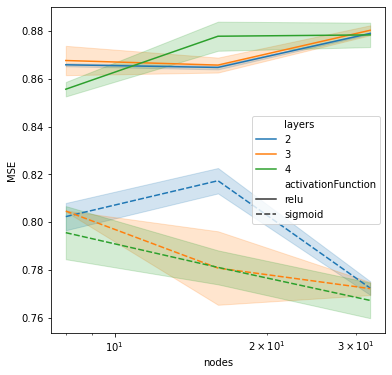

In [321]:
fig, ax = plt.subplots(figsize=(6,6))

sns.lineplot(ax=ax,
             data=resultsLong2,
             x='nodes',
             y='MSE',
             hue='layers',
             style='activationFunction',
             palette='tab10',
             
             #y
            )
ax.legend()
ax.set_xlabel('nodes')
ax.set_ylabel('MSE')

ax.set(xscale="log")#, yscale="log")

https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

#### Test Best Model

In [322]:
best = newModel(4, 32, 'sigmoid')

In [329]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)

historyBest = best.fit(X_trainLoss,
                    y_trainLoss,
                    validation_data=(X_validateLoss,
                                     y_validateLoss),
                    epochs=1000,
                    batch_size=64,
                    verbose=0,
                        callbacks=[es]
                   )

Epoch 00080: early stopping


(0.0, 0.5)

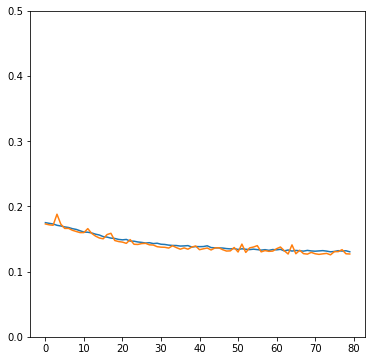

In [331]:
fig, ax =plt.subplots(figsize=(6,6))

ax.plot(historyBest.history['loss'], label='train')
ax.plot(historyBest.history['val_loss'], label='validate')

ax.set_ylim([0, 0.5])

In [332]:
bestPred = best.predict(X_test)

In [333]:
bestPred

array([[-1.0926963 ],
       [-0.13992654],
       [ 0.14557756],
       ...,
       [-0.48154464],
       [-1.0562218 ],
       [-0.12411742]], dtype=float32)

In [335]:
y_test

array([277000., 364500., 471000., ..., 345000., 305000., 450000.])

In [336]:
bestPredPlot = invert(bestPred)
#yTestPlot = invert(y_)

bestPredPlot

array([260594.86, 430821.78, 500867.  , ..., 359761.16, 265658.88,
       434430.6 ], dtype=float32)

Text(0, 0.5, 'Prediction')

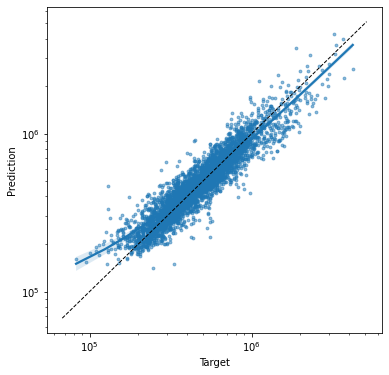

In [337]:
fig, ax = plt.subplots(figsize=(6,6))

ax = sns.regplot(x=y_test,
                 y=bestPredPlot,
                 scatter_kws={'s':8,
                              'alpha':0.5},                
               )

ax.set(xscale="log", yscale="log")

xpoints = ypoints = ax.get_xlim()
ax.plot(xpoints, ypoints, linestyle='--', color='k', lw=1)#, scalex=False, scaley=False)

#ax = sns.lineplot(x=[0,1], y=[0,1])#, transform=ax.transAxes)

#ax.axis('equal')

ax.set_xlabel('Target')
ax.set_ylabel('Prediction')

In [338]:
mean_squared_error(y_test, bestPredPlot, squared=False) 

138696.5957849268